# 프로젝트 : CIFAR-10 이미지 생성하기
GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

```
airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck
```

# STEP 0. 작업환경 구성하기
다음과 같이 작업환경을 구성합시다.
```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.datasets.cifar10 import load_data
# 케라스로 cifar10 다운로드

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:

# example of loading the cifar10 dataset
from tensorflow.keras.datasets.cifar10 import load_data
# load the images into memory
(trainX, _), (testX, _) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainX.shape)
print('Test', testX.shape, testX.shape)

Train (50000, 32, 32, 3) (50000, 32, 32, 3)
Test (10000, 32, 32, 3) (10000, 32, 32, 3)


#### keras에서 cifar-10 가져옴(여기서는 사용안함)


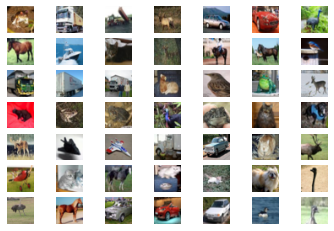

In [3]:
# keras에서 cifar-10 가져옴
# 여기서는 사용안함
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
pyplot.show()

# STEP 1. 데이터셋 구성하기
CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

- 파이썬 언더스코어(_) 사용해서 데이터셋 다운로드(언더스코어를 사용하면 지정된 변수공간을 비워도 에러가 뜨지 않는다.)
https://mingrammer.com/underscore-in-python/#2-%EA%B0%92%EC%9D%84-%EB%AC%B4%EC%8B%9C%ED%95%98%EA%B3%A0-%EC%8B%B6%EC%9D%80-%EA%B2%BD%EC%9A%B0

- 5만개의 32x32크기의 이미지(RGB적용된)

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

## 학습 데이터 정규화
### 다운로드 받은 픽셀의 최고 값은 255, 최저값은 0이다.


In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


###  정규화 전 이미지 출력

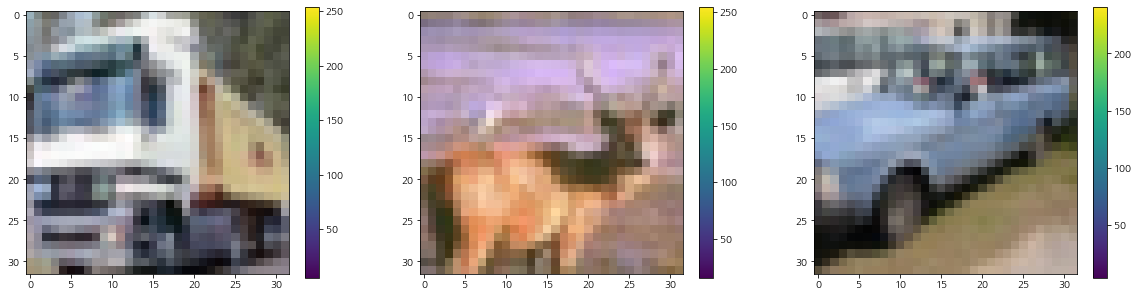

In [6]:

plt.figure(figsize= (20,5))
#plt.title('load data')
plt.subplot(1, 3, 1) 
plt.imshow(train_x[1])
plt.colorbar()

plt.subplot(1, 3, 2) 
plt.imshow(train_x[9000])
plt.colorbar()

plt.subplot(1, 3, 3) 
plt.imshow(train_x[7777])
plt.colorbar()

plt.show()

### 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화
각 픽셀을 -1, 1로 정규화시킨다.    
중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.

In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 정규화 후 이미지


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


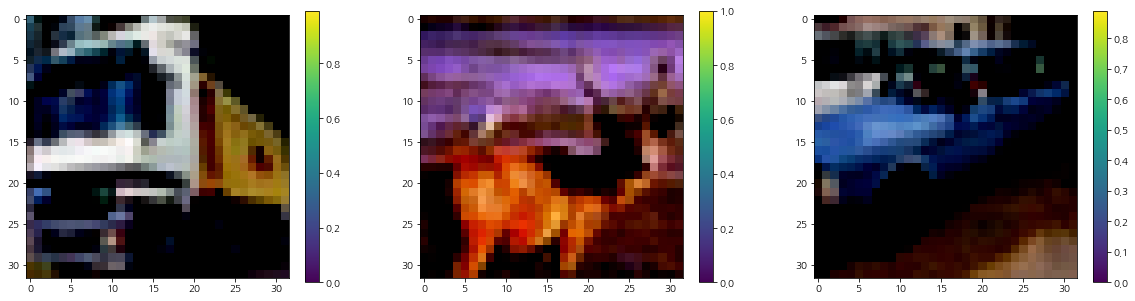

In [8]:

plt.figure(figsize= (20,5))
#plt.title('load data')
plt.subplot(1, 3, 1) 
plt.imshow(train_x[1])
plt.colorbar()

plt.subplot(1, 3, 2) 
plt.imshow(train_x[9000])
plt.colorbar()

plt.subplot(1, 3, 3) 
plt.imshow(train_x[7777])
plt.colorbar()

plt.show()

### 25개 이미지 랜덤으로  보기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

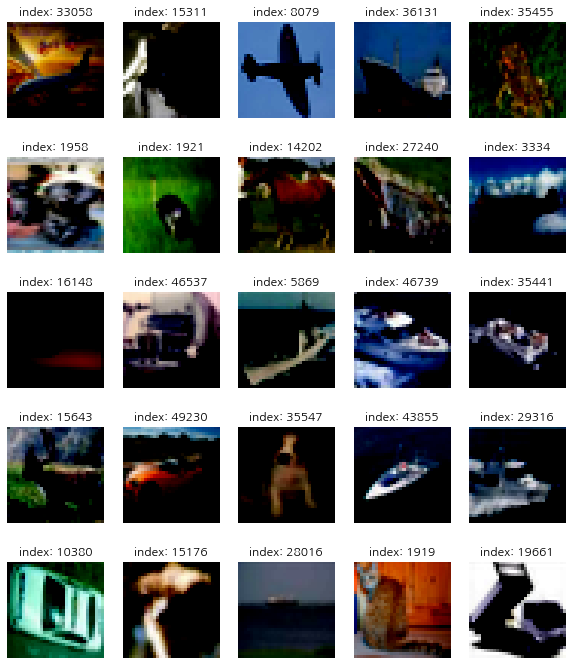

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

## 미니베치 데이터셋 구성하기 
- tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해보자
- BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정합니다. 
- shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어준다
       
       
- BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양이다.   
많은 양을 한 번에 학습시키면 메모리적으로 비효율적, 한 번 학습을 하는 데에도 오래 걸린다.
적절한 사이즈로 잘라서 학습시킨다. 이런 방식을 미니배치 학습 이라고 합
   

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

#### tf.data.Dataset 모듈의 from_tensor_slices() 함수   
-특정 자료형(리스트,넘파이,텐서플로우의 텐서)에서 데이터셋을 만들수 있다. 
   
```   
밑 코드는 train_x(넘파이 배열)의 값들을 섞고, 이를 배치 사이즈로 나눠도록 한다.  
데이터가 잘 섞이게 하기 위해 버퍼 사이즈(BUFFER_SIZE)를 총 데이터 사이즈(5만개)와 같거나 크게 설정해주자(이렇게 해는게 좋다고한다.)
```

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# GAN 개념

# STEP 2. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수만들기
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성하기
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인하기

## 생성자 구현함수

노드에서 제공하는 이미지는 (28,28,1)이였다. cifar에서 제공하는 이미지는 (32,32,3)이다. 즉 입력 이미지의 shape가 다르므로 그에 맞게 변경해주자.

https://stackoverflow.com/questions/56745420/tensorflows-tutorial-gan-not-working-for-cifar-10

https://colab.research.google.com/drive/1NWUrPJLLVvA-THpv2XqEgYeemuFl3Qj-   
참조하였다.

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    # Second: Reshape layer
    #model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

   
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)


    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

## 노이즈 벡터 생성(랜덤 이미지)
 -의미 없는 벡터 생성    
 (이 벡터는 현재는 의미없는 벡터 있지만 학습을 통해 의미있는 이미지로 만들어진다.즉 가짜이미의 초기이미지)

In [14]:
noise = tf.random.normal([1, 100])

## 생성자 모델 실행
- 생정자 모델에 노이즈 벡터 넣기
- 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 한다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있습니다.

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


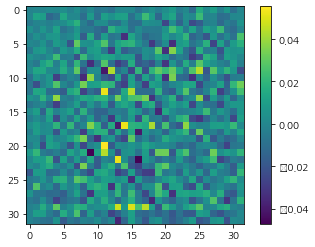

In [16]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

 -1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있습니다. 

# STEP 3. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수 생성
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인하기

## 판별자 구현 함수

In [21]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                      input_shape=[32, 32, 3]))
    # First: Conv2D Layer                            
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [23]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

## 판별자 모델 실행
아까 생성했던 가짜 이미지를 판별자에 입력하기    
generated_image는 노이즈 벡터이다.(가짜이미지)



In [24]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00478554]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 되었다. 이 값 또한 아직은 아무런 의미가 없는 값이다.

# STEP 4. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

## 크로스 엔트로피 손실함수

#### 크로스엔트로피 손실함수
 점점 가까워지기을 원하는 두값이 있을때, 두값이 얼마나 큰 차이가 나는지를 정략적으로 계산할때 쓰인다.   
 신경망 출력을 확률로 간주 할 수 있는 경우에 사용되는 손실 함수    
https://hyunw.kim/blog/2017/10/14/Entropy.html

   
     

교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있다.

다만, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠.

그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다    
(참고). 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#args_1

#### 생성자와 판별자의 목적이 무엇이인가? 
생성자는 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어 합니다.   
판별자는 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것이 목표입니다.

 Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠죠.

생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것
결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요! 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해 봅시다.

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### fake_output와 real_output 무엇인가?
 -cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.
- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값 (fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값 (real_image)

#### tf.ones_like()
입력 shape의 모양의 tensor값으로 변경,이때 각 인덱스의 값은 1로 변경됨
#### tf.zeros_like()
입력 shape의 모양의 tensor값으로 변경,이때 각 인덱스의 값은 0로 변경됨

### generator_loss
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다. 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산한다.   
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 된다.

최종 discriminator_loss 값은 이 둘을 더한 값이다.

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다.

fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

In [28]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 생성자와 판별자를 최적화하는 최적화 함수 optimizer
- Adam 최적화 기법 을 활용- 
- 생성자와 판별자는 따로 학습을 진행하는 네트워크이기 때문에 optimizer를 각각 만들어 줘야된다.

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 샘플은 한 번에 16장을 생성
-  생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다. 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만든다.

In [30]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 5. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.


참고: python decorator (데코레이터)
https://bluese05.tistory.com/30

@tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다. 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있다.

## 훈련과정 함수로 만들기
-1개 미니배치의 훈련 과정을 처리하는 train_step() 함수

In [31]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.
```
(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
(7) accuracy 계산 : fake_output, real_output으로 discriminator가
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴
```

### 학습 정보 제공 함수(학습중인 이미지 저장)
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수

In [32]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0])
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

###  학습 정보 제공 함수(epoch에 따른 히스토리 저장)
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.

In [33]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

# checkpoint 저장 함수 
- tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.
- checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장한다.   
checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용 할것이다.

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 6. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다

## train 함수 생성
1)지금까지 한 단계를 학습하는 train_step,    
2)샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(),   
3)학습 과정을 시각화하는 draw_train_history(),   
4)모델 저장하기 위한 checkpoint   
이 모든 것을 하나의 train함수에 적용하겠다.   

In [35]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### 파라미터 설정
모델을 저장하는 간격을 담당하는 save_every    
전체 학습 에포크를 결정하는 EPOCHS    

처음부터 에포크 1000으로 설정

In [73]:
# 처음부터 에포크 1천으로 설정
save_every = 5
EPOCHS = 1000 

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

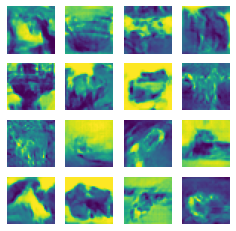

Time for training : 12647 sec


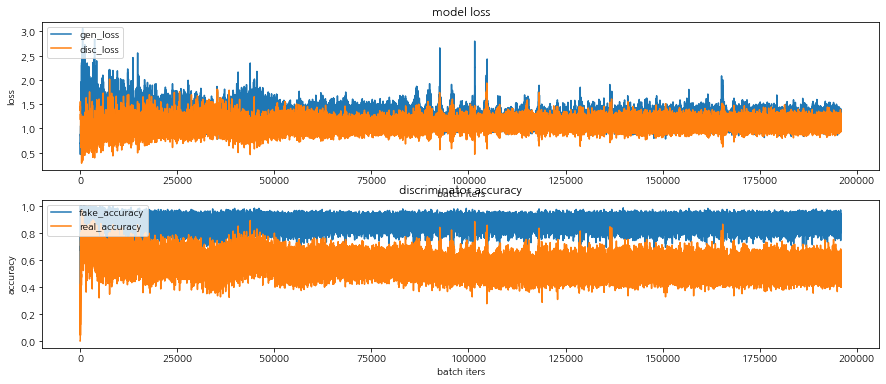

CPU times: user 3h 31min 35s, sys: 6min 52s, total: 3h 38min 28s
Wall time: 3h 30min 52s


In [116]:
%%time
train(train_dataset, EPOCHS, save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 훈련된 이미지 gif로 저장하기
현재 이외 여러번의 학습모델을 돌릴것인데, 훈련과정 이미지 저장코드를 생략하겠다.

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_epochs1000.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/fashion/cifar10_dcgan_epochs1000.gif    

# 1000번의 에포크가 설정된 모델에서 나온 노이즈벡터를 가지고 다시 50의 에포크로 모델을 돌렸다.
```
- gif 저장 코드는 생략한다.
- generate_and_save_images함수를 수정하였다.(현재 쥬피터노트북의 generate_and_save_images함수는 수정된 상태이다.)
  기존의 plt.imshow(predictions[i, :, :, 0])   ->>>>   plt.imshow(predictions[i] * 0.5 + 0.5) 로 수정
  변경한 이유는 train()함수에서 이미지출력을 더 적절히 보여주기 위함이다.(색깔이 더 잘나온다.)
```        

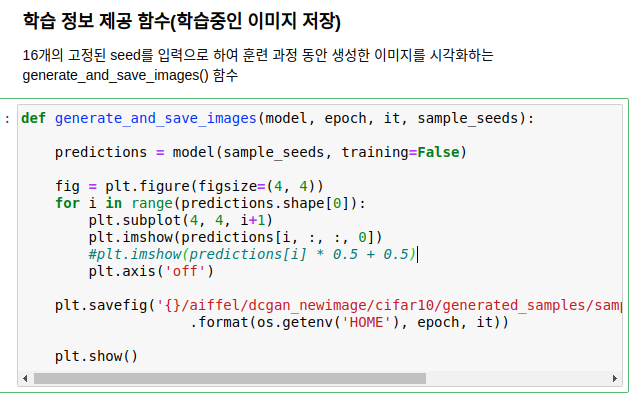

In [153]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

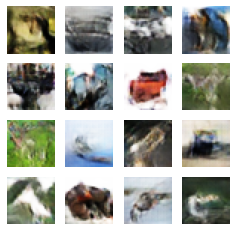

Time for training : 539 sec


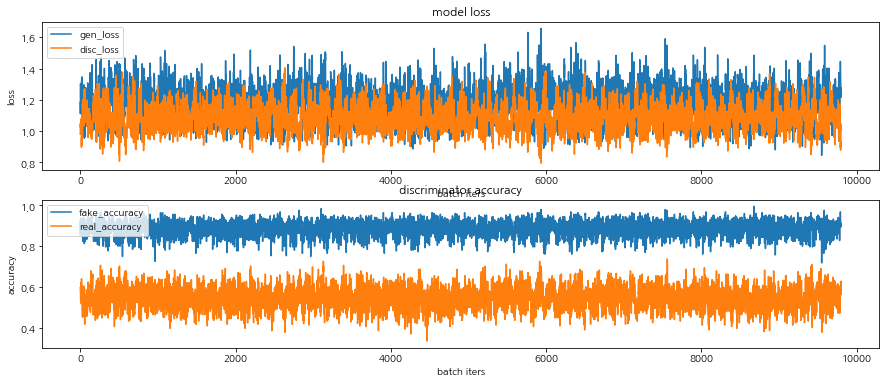

CPU times: user 9min 3s, sys: 20.6 s, total: 9min 24s
Wall time: 9min


In [154]:
%%time
train(train_dataset, EPOCHS, save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

# (1000에포크)-> (50에포크)가 설정된 모델에서 나온 노이즈벡터를 가지고 다시 500의 에포크로 모델을 돌렸다.

In [208]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

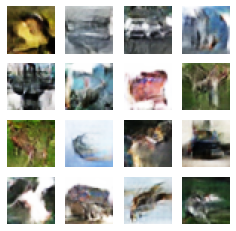

Time for training : 6194 sec


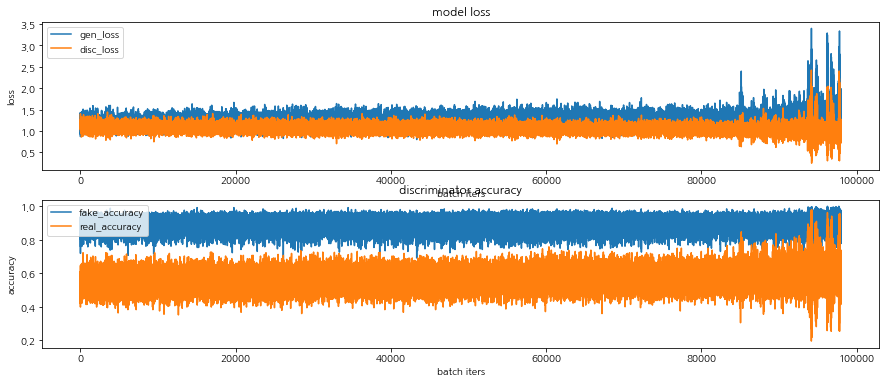

CPU times: user 1h 43min 48s, sys: 3min 23s, total: 1h 47min 12s
Wall time: 1h 43min 18s


In [209]:
%%time
train(train_dataset, EPOCHS, save_every)

In [210]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_epochs1550.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
!ls -l ~/aiffel/dcgan_newimage/fashion/cifar10_dcgan_epochs1000_50_1550.gif    

ls: cannot access '/home/aiffel-dj60/aiffel/dcgan_newimage/fashion/cifar10_dcgan_epochs1000_50_1550.gif': No such file or directory


# 에포크 1500 설정(노이즈벡터 초기화후)

In [31]:
save_every = 10
EPOCHS = 1500


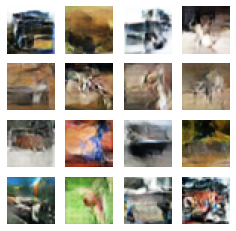

Time for training : 20503 sec


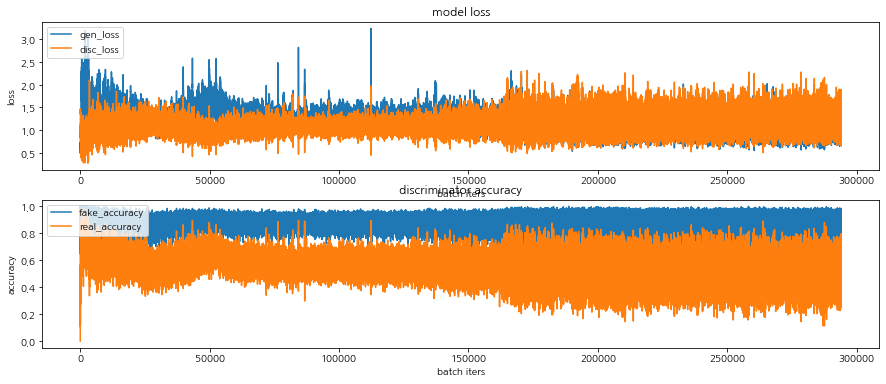

CPU times: user 5h 42min 56s, sys: 10min 13s, total: 5h 53min 10s
Wall time: 5h 41min 51s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

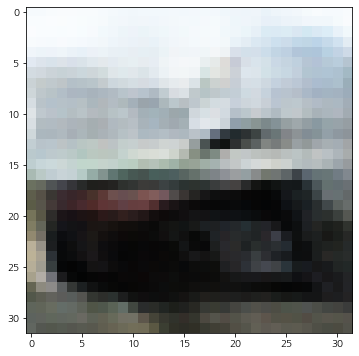

In [334]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_1500'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### 이미지가  잘 표현이 되지 않는다

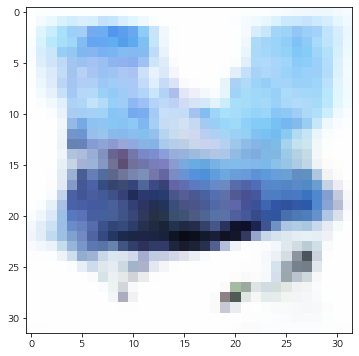

In [248]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints _epochs1000'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.


# gif 그림

gif 이미지경로
https://github.com/SIMYJ/EXPLORATION_Project/tree/master/%5BE12%5DGAN_cifar10/%EC%97%90%ED%8F%AC%ED%81%AC%EC%97%90%20%EB%94%B0%EB%A5%B8%20%EC%9D%B4%EB%AF%B8%EC%A7%80

https://github.com/SIMYJ/EXPLORATION_Project/issues/1

에포크 1000일때    
![1 에포크1000](https://user-images.githubusercontent.com/59362727/109519484-9f660300-7aee-11eb-8e81-0f86fbf4b54b.gif)


에포크 1000후 50더 추가할때
![2에포크1000+50](https://user-images.githubusercontent.com/59362727/109519558-b0af0f80-7aee-11eb-86aa-dc8cdad4053d.gif)


에포크 1000+50후 500 추가할때

![3에포크1500+50+500](https://user-images.githubusercontent.com/59362727/109520043-261ae000-7aef-11eb-88d0-283429dcd9fa.gif)

---------------------------------------------------------------------------------
에포크 1500일때
![4 에포크1500 ](https://user-images.githubusercontent.com/59362727/109516987-26fe4280-7aec-11eb-8999-7e323e15c171.gif)


# 질문 & 학습 내용

#### 1.imageio, pillow(PIL) 라이브러리가 각각 쓰임은?
1). image는 이미지를 불러오는 라이브러리(파이썬에서 이미지를 불러오는 라이브러리 대표적 cv2, imageio 2개이다.) https://greatjoy.tistory.com/m/49?category=704495 
   
2). pillow는 이미지 처리 라이브러리

#### 2.파이썬 언더스코어(_) 란
할당 변수자리를 빈공간으로 설정하는방식.   
ex) (train_x, _), (test_x, _) = fashion_mnist.load_data()


#### 3.이미지의 각 픽셀을 -1,1로 정규화(중간값 0으로 설정) 시키 위해 127.5로 뺀후 127.5로 나누워 준다. 그런데 왜 이런 작업을 왜 하는가?
학습시 더 효과적이고, local optimum에 빠지는 가능성을 줄여준다.

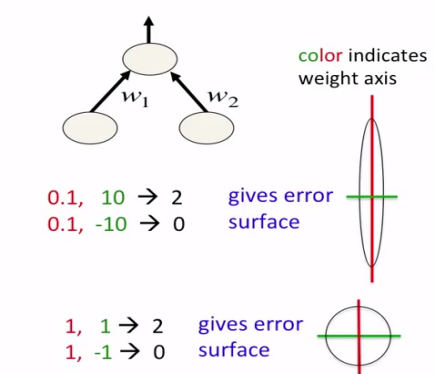

Elongated(길쭉한) 된 것 보다 Spherical(둥근) 한 것이 Gradient descent 방법으로 찾아갈 때 더 빠를 것이라고 한다.    
 https://light-tree.tistory.com/132 [All about]


####  4. Fashion MNIST의 기존의 모양은 (60000, 28, 28) 이였다.(60000, 28, 28,1)로 바꾸는 이유는 무엇인가? 
6만개의 28x28(가로,세로) 이미지를 의미하는데 마지막 1을 추가한 이유는 흑백에 대한 채널를 추가한것이다.   
cifiar-10은 rgb를 활용하기 때문에 (None,32,32,3) 모양을 가질것이다.


#### 5. Fashion MNIST는 흑색이미지라고 하였다.plt.imshow(train_x[0])하면 왜 컬러 색 출력되는건가?
흑백 사진을 굳이 컬러 출력으로 표현했기때문인것 같다. 그러므로 아래 와 같이 출력하자
-  plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')

#### 6. 5번의 코드처럼 흑백으로 출력 했다. 그런데  fashion이미지는 28x28인데 굳이 또 reshape해주는것인가?
확인차 한번더 28x28해준것 같다.

#### 7. 배치 사이즈는 무엇인가?
- BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양입니다.   
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행시킨다. 이러한 방식을 미니배치 학습 이라고 한다.



#### 8. GAN(Generative Adversarial Network)이란
- 생성 모델 중 하나이다. 
- GAN의 loss function는 cross entropy이다.맞냐?  
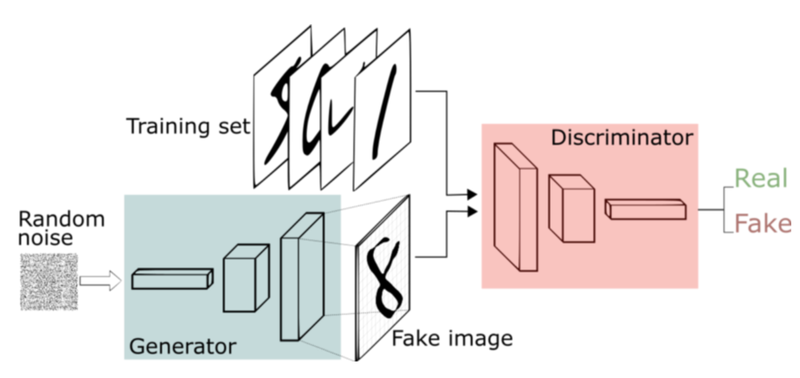

#### 9. GAN의 생성자(Generator), 판별자(Discriminator)
- 생성자(Generator)   
아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성한다. 즉 무에서 유 창조
- 판별자(Discrimiator)   
기존에 있던 real이미지,생성자가 만든 Fake이미지를 입력 받아 각 이미지가 real인지,Fake인지에 대한 판단하여 정도를 실수값으로 출력    


Generative Model : 위조지폐를 만들어내는 팀    
Discriminative Model : 위조 지폐범을 잡아내는 경찰   
http://seb.kr/w/GAN


#### 10.  DCGAN (Deep Convolutional GAN) 
-GAN 중 특히 합성곱 층(Convolutional Layer)으로 이루어진 딥러닝 모델
https://openai.com/blog/generative-models/    
위 사이트에서 CGAN은 무엇을 입력받아 무엇을 출력하나요?
- Input : 100 random numbers drawn from a uniform distribution (called as a code, or latent variables)    

- Output : an image (in this case 64x64x3 images)    


#### 10.1  latent variable(잠재변수)
latent variable이란 은닉변수라고한다. 복잡한 계산을 하기 위해 중간에 계산되는 숨은 변수 정도로 이해하면된다.   
https://gongnorina.tistory.com/62      
https://m.blog.naver.com/PostView.nhn?blogId=jaehyubious&logNo=220683847945&proxyReferer=https:%2F%2Fwww.google.com%2F    



#### 10.2 균일 분포(uniform distribution)
균일 분포는 이산형확률분포, 연속형확률분포 두 형태 모두가 존재한다. 표현식의 차이가 있을 뿐, 특정 범위 내에서 분포가 균등하게 나타난다는 개념은 동일합니다.
https://losskatsu.github.io/statistics/uniformdist/#%EC%B0%B8%EA%B3%A0-%ED%99%95%EB%A5%A0%EB%B6%84%ED%8F%AC%EA%B0%84-%EA%B4%80%EA%B3%84%EB%8F%84


Tensorflow 2.0 Tutorial의 DCGAN 구현    
https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko   
텐서플로 추상화와 간소화, Keras   
https://excelsior-cjh.tistory.com/159 [EXCELSIOR]


참고: What is Transposed Convolutional Layer?   
https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11

참고: 라온피플-Batch Normalization   
https://m.blog.naver.com/laonple/220808903260

참고: 활성화 함수 (activation function)   
https://newly0513.tistory.com/20

#### 11. 크로스엔트로피 손실함수     
 점점 가까워지기을 원하는 두값이 있을때, 두값이 얼마나 큰 차이가 나는지를 정략적으로 계산할때 쓰인다.   
 신경망 출력을 확률로 간주 할 수 있는 경우에 사용되는 손실 함수    
https://hyunw.kim/blog/2017/10/14/Entropy.html
 
 
#### 12. 노드에서 GAN을 포함해 총 세 가지의 생성 모델링 기법을 소개하였습니다. 나머지 두 가지는 무엇인가요?
1.Variational Autoencoders (VAEs)    
2.Autoregressive models (ex. Pixel RNN)    


#### 13. 노이즈 벡터란?
- 노이즈 벡터라 의미없는 랜덤값으로 만들어진 벡터이다.       
- 생성자의 초기 입력 벡터를 노이즈 벡터로 받는다.이 벡터는 학습을 통해 점점 이미지 있는 벡터로 변환된다.


#### 14.데코레이터
- #### @tf.function       
Numpy array 입력 x, y를 동일하게 사용했지만 f(x,y)의 결과 타입은 다릅니다. @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다. 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것 같습니다.
- python decorator (데코레이터) 
https://bluese05.tistory.com/30   
https://dojang.io/mod/page/view.php?id=2427    

#### 15.에포크를 1000번 적용한 노이즈벡터에 50 에포크로 학습을 한다면 그것은 학습이 잘된것인가?
- 생성자 입력값인 노이즈벡터(가짜 이미지)를 진짜이미지 인것처럼 학습하는것이기 때문에 적절하다고 생각된다.

#### 16 Conv2DTranspose의 쓰임[12-9]     
https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d


#### gen_loss disc_loss 과 fake_accurancy, real_accuracy 에대해 더 주의깊게 보자.

In [ ]:
https://github.com/SIMYJ/EXPLORATION_Project/blob/master/%5BE12%5DGAN_cifar10/%EC%97%90%ED%8F%AC%ED%81%AC%EC%97%90%20%EB%94%B0%EB%A5%B8%20%EC%9D%B4%EB%AF%B8%EC%A7%80/4.%EC%97%90%ED%8F%AC%ED%81%AC1500%20.gif?raw=true

# 코드

#### plt.colorbar()  이미지의 칼라 바    

#### plt.figure(figsize=(10, 5))는 이미지의 전체 프레임의 크기를 결정        

#### plt.subplot(row, col, index)  subplot의 위치 결정        


#### tf.ones_like()        
입력 shape의 모양의 tensor값으로 변경,이때 각 인덱스의 값은 1로 변경됨        


#### tf.zeros_like()        
입력 shape의 모양의 tensor값으로 변경,이때 각 인덱스의 값은 0로 변경됨        
   
----------------------------------
  
#### fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)            
#### real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)        

------------------------------------
####  generator_loss는 fake_output가 1에 가까워지기를 바라므로 밑과 같이 계산    
cross_entropy(tf.ones_like(fake_output), fake_output)        
fake_output값이 1에 가까울수록 작은 값 가짐(실제 이미지와 비슷할수록 1에 가까워진다.)        

#### discriminator_loss는 real_output 값은 1에 가까워지기로,fake_output 값은 0에 가까워지기를 바라므로        
[코드]   
real_loss = cross_entropy(tf.ones_like(real_output), real_output)    
fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)    
total_loss = real_loss + fake_loss

------------------------------------------------

#### tf.data.Dataset 모듈의 from_tensor_slices() 함수   
-특정 자료형(리스트,넘파이,텐서플로우의 텐서)에서 데이터셋을 만들수 있다.    
- 밑 코드는 train_x(넘파이 배열)의 섞고, 이를 배치 사이즈로 나눠도록 한다.  
데이터가 잘 섞이게 하기 위해 버퍼 사이즈(BUFFER_SIZE)를 총 데이터 사이즈(5만개)와 같거나 크게 설정해주자(이렇게 해는게 좋다고한다.)    

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)    


### cifar-10를 활용한  GAN모델 사용 코드

https://stackoverflow.com/questions/56745420/tensorflows-tutorial-gan-not-working-for-cifar-10

https://colab.research.google.com/drive/1NWUrPJLLVvA-THpv2XqEgYeemuFl3Qj- 

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

---